In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import gensim 

In [2]:
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/Documents/Data/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import *
from utils.tm_mgmt import update_topic_scores
from utils.text import *
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V

In [8]:
# Defining get_coherence
# Modified for parliament 
def get_coherence(run_id, search_id):
    stat = RunStats.objects.get(run_id=run_id)
    K = stat.K
    print("Getting coherence for {}".format(run_id))
    # obtain utterances in run_id 
    uts = pm.Utterance.objects.filter(search_matches=search_id)
    # obtain paragraphs from utterances in queryset  
    texts = []
    for ut in uts:
        pars = ut.paragraph_set.all()
        texts.append(" ".join([x.text for x in pars]))

    sentences = [get_sentence_g(x) for x in texts]
    model = gensim.models.Word2Vec(sentences)
    print("Calculating model similarity)")
    validation_measure = WithinTopicMeasure(
        ModelSimilarity(model)
    )

    term_rankings = []

    topics = Topic.objects.filter(
        run_id=run_id
    )

    for topic in topics:
        term_ranking = list(Term.objects.filter(
            topicterm__topic=topic
        ).order_by(
            '-topicterm__score'
        ).values_list('title',flat=True)[:50])
        term_rankings.append(term_ranking)

    stat.coherence = validation_measure.evaluate_rankings(
        term_rankings
    )
    stat.save()
    print("Coherence obtained.")
    print(stat.coherence)
    return

In [6]:
run_ids = [1350, 1351, 1352, 1353]

In [7]:
s = pm.Search.objects.get(id=44)

In [9]:
for run_id in run_ids:
    get_coherence(run_id, s)

Getting coherence for 1350
Calculating model similarity)
Coherence obtained.
0.4095878632824845
Getting coherence for 1351
Calculating model similarity)
Coherence obtained.
0.4170903415919083
Getting coherence for 1352
Calculating model similarity)
Coherence obtained.
0.40312689734446033
Getting coherence for 1353
Calculating model similarity)
Coherence obtained.
0.41716396235815933


In [3]:
sns.set_style('whitegrid')

In [4]:
Ks = [40, 50, 60, 70]

In [7]:
coherences = []
for run_id in run_ids:
    coherences.append(RunStats.objects.get(run_id=run_id).coherence)

In [13]:
coherences

[0.409587863282484, 0.417090341591908, 0.40312689734446, 0.417163962358159]

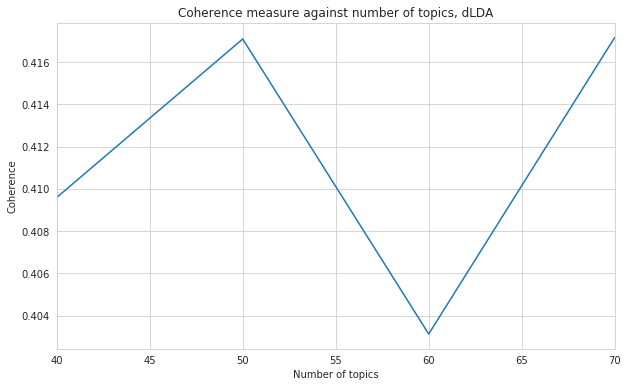

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(Ks, coherences, ax = ax)
ax.set(xlim=(40,70),xlabel="Number of topics",ylabel="Coherence", title="Coherence measure against number of topics, dLDA")
plt.show()